# **miniML Tutorial**



## Setting up

We begin by importing the required parts of the miniML package.

In [11]:
import sys
sys.path.append('./core/')
from miniML import MiniTrace, EventDetection

## Running miniML

For the actual data analysis, we first need to load the data and create a miniML *MiniTrace* object. Currently accepted file formats are HDF5, Axon ABF and HEKA DAT. In this example, we load the dataset ['mini_data'] from an .h5 file. Data can be scaled for convenience. Provide the sampling interval (in seconds, e.g., *sampling=1e-5*) if the sampling rate is not 50 kHz.

In [12]:
filename = './example_data/gc_mini_trace.h5'
scaling = 1e12
unit = 'pA'

# get from h5 file
trace = MiniTrace.from_h5_file(filename=filename,
                               tracename='mini_data',
                               scaling=scaling,
                               unit=unit)

Data loaded from ./example_data/gc_mini_trace.h5 with shape (6000000,)


Data can also be loaded from, e.g., Axon binary files (.abf):

```
filename = './example_data/gc_mini_trace.abf'
scaling = 1
unit = 'pA'

# get from ABF file
trace = MiniTrace.from_axon_file(filepath=filename,
                                 channel=0,
                                 scaling=scaling,
                                 unit=unit)
```

Let's plot and inspecet the loaded data:

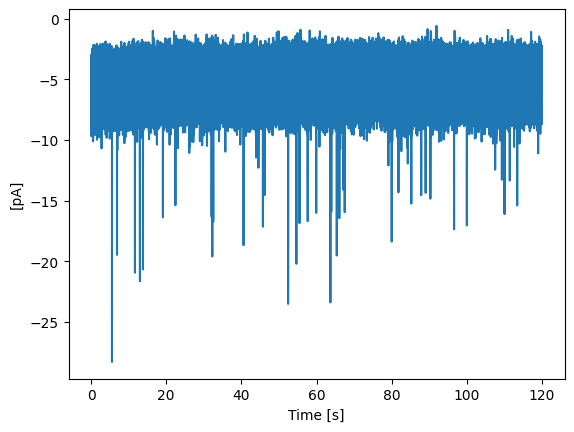

In [13]:
trace.plot_trace()

Next, we need to create and initialize a miniML *EventDetection* object. Required arguments are a miniML MiniTrace object to work on and the path to a miniML model file. Optionally, the threshold for event detection can be adjusted (range, 0–1). The batch_size parameter can be changed to reduce runtime when running on a GPU (caveat: too large batch sizes can cause poor model prediction performance).

In [14]:
win_size = 600
stride = int(win_size/30)
direction = 'negative'

detection = EventDetection(data=trace,
                           model_path='./model/GC_lstm_model.h5',
                           window_size=win_size,
                           model_threshold=0.5,
                           batch_size=512,
                           event_direction=direction,
                           compile_model=True)

Model loaded from ./model/GC_lstm_model.h5


To detect events, we have to call the **detect_events()** method. We can provide a stride length, i.e. numbers of samples the analysis window is shifted by for each iteration. Defaults to 20 (i.e., 1/30 of the window size used for model inference). Set the eval flag to **False** if you do not want to analyse the detected events.

In [15]:
detection.detect_events(stride=stride,
                        eval=True,
                        verbose=True)

586/586 [==============================] - 15s 24ms/step

Event statistics:
-------------------------
    Number of events: 43
    Average score: 0.958
    Event frequency: 0.3583 Hz
    Mean amplitude: -9.6859 pA
    Median amplitude: -9.5819 pA
    Std amplitude: 4.3086 pA
    CV amplitude: 0.445
    Mean charge: -0.01387 pC
    CV charge: 0.484
    Mean 10-90 risetime: 0.343 ms
    Mean half decay time: 0.769 ms
    Tau decay: 1.223 ms
-------------------------


## Inspect the results

After the event detection and analysis, we can create some plots. MiniML includes several plotting methods: 

**plot_prediction()** shows the model inference trace, optinally together with the data and marked events. Note that we plot a filtered version of the trace in this example.

**plot_events()** creates a figure with all detected events overlaid. 

**plot_event_histogram()** plots a histogram of event amplitudes (optional: inter-event-intervals). Set *cumulative=True* for a cumulative probability plot.

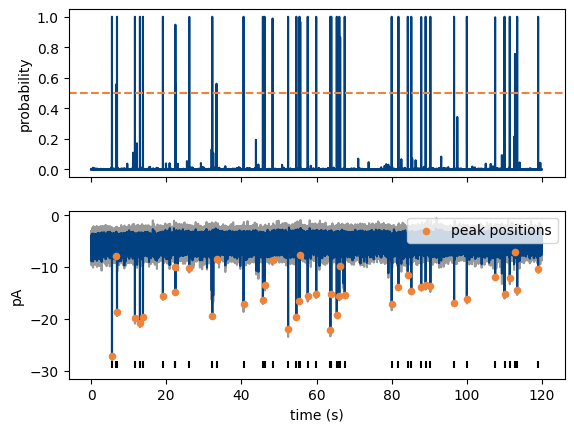

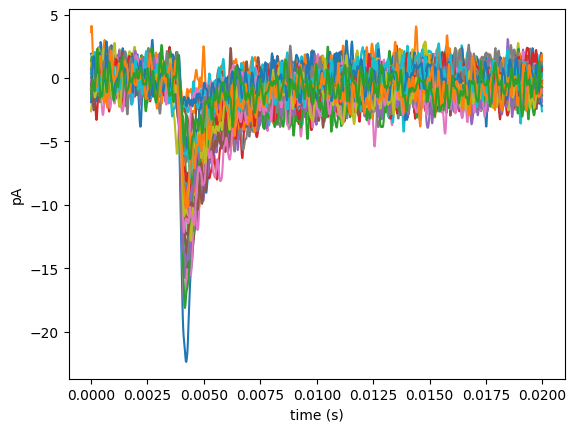

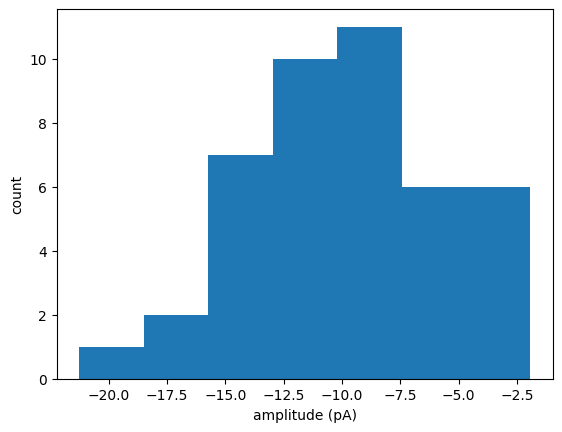

In [16]:
detection.plot_prediction(include_data=True, plot_filtered_prediction=True, plot_filtered_trace=True)
detection.plot_events()
detection.plot_event_histogram(plot='amplitude', cumulative=False)

## Save results to file

Finally, we can save the results to file for later use. The **save_to_pickle()** method saves the data in pickle format (essentially a python dictionary). If desired, the mini trace and the generated prediction trace can be saved as well. Note that this will increase file size.

In [17]:
detection.save_to_pickle(filename='./example_data/results/gc_mini_trace_results.pickle', 
                         include_prediction=True, 
                         include_data=False)

events saved to ./example_data/results/gc_mini_trace_results.pickle


The **save_to_h5()** method saves the detected events and the individual event statistics to a specified HDF5 file. It also includes average results for amplitude, charge, frequency, etc.

In [18]:
detection.save_to_h5('./example_data/results/gc_mini_trace_results.h5')

Events saved to ./example_data/results/gc_mini_trace_results.h5


In addition, results can be saved in a delimited text format using **save_to_csv()**. This methods takes a destination folder path and saves two .csv files containing event population statistics and individual event statistics, respectively.

In [19]:
detection.save_to_csv(filename='./example_data/results/gc_mini_trace.csv')

events saved to ./example_data/results/gc_mini_trace_avgs.csv and ./example_data/results/gc_mini_trace_individual.csv
